Importando módulos

In [4]:
import pandas as pd
import numpy as np
from pycaret.datasets import get_data
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from dataprep.eda import create_report

Selecionando base de estudo e fazendo análise descritiva dos dados

In [5]:
df = get_data('titanic')
data_report = create_report(df, title='Report Titanic')
data_report.show_browser()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


  0%|          | 0/1420 [00:00<?, ?it/s]

Selecionando e separando variáveis, aqui também já substituímos os valores em branco que percebemos na análise anterior. <br>
Eles serão substituídos pelo valor médio da coluna, que no caso é a coluna "Age". <br>
Aqui também definimos nosso Target, que será a coluna "Survived".

In [6]:
x = df[['Fare','Age','Sex']]
x = x.fillna(x['Age'].mean())
y = df[['Survived']]

Temos uma coluna categórica, que é a coluna de "sex", então precisamos convertê-la para um formato numérico, <br>
e para isso usamos a classe "OneHotEncoder"

In [7]:
x_type = x.select_dtypes(include='object')
onehot = OneHotEncoder(sparse=False, drop='first')
x_bin = onehot.fit_transform(x_type)

Nesta etapa, faremos a normalização dos dados para uma mesma escala, a fim de minimizar o impacto de valores acentuados na predição.

In [8]:
normalizador = MinMaxScaler()
x_norm = normalizador.fit_transform(x.select_dtypes(exclude='object'))
x_all = np.append(x_norm,x_bin, axis=1)

Definindo base de treino e teste

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y, train_size= 0.75, random_state= 42)

Ajustando hiperparâmetros do algorítmo selecioado

In [10]:
RFC = RandomForestClassifier(n_estimators= 350,
                            max_depth= 10, 
                            max_features= None,
                            max_samples=None
                            )

Treinando, testando, e verificando a acurácia

In [11]:
RFC.fit(x_train,y_train)
predict = RFC.predict(x_test)
accuracy_score(y_test, predict)

0.7892376681614349

Avaliando com base de teste com report completo

In [12]:
report_predict = classification_report(y_test, RFC.predict(x_test))
print(report_predict)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       134
           1       0.78      0.66      0.72        89

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223



Visualização dos dados com heatmap

<AxesSubplot: >

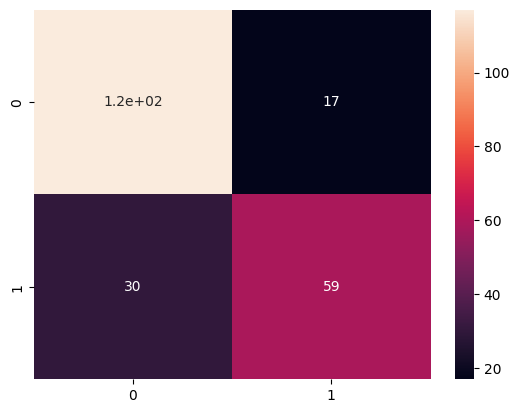

In [13]:
sb.heatmap(confusion_matrix(y_test, RFC.predict(x_test)), annot=True)

Agora vamos ajustar a base completa para fazer a predição

In [14]:
#Base Completa
x_bim_total = onehot.transform(x.select_dtypes(include='object'))
y_num_total = normalizador.transform(x.select_dtypes(exclude='object'))
x_new_all = np.append(y_num_total, x_bim_total, axis=1)

Faremos então a predição, e exibiremos tudo em um único DataFrame, podendo comparar as colunas

In [17]:
x_copy = x.copy()
x_copy['Predição'] = RFC.predict(x_new_all)
x_copy['Sobreviveu'] = y
display(x_copy)

,Fare,Age,Sex,Predição,Sobreviveu
0,7.2500,22.000000,male,0,0
1,71.2833,38.000000,female,1,1
2,7.9250,26.000000,female,1,1
3,53.1000,35.000000,female,1,1
4,8.0500,35.000000,male,0,0
...,...,...,...,...,...
886,13.0000,27.000000,male,0,0
887,30.0000,19.000000,female,1,1
888,23.4500,29.699118,female,1,0
889,30.0000,26.000000,male,1,1


Verificando Acurácia na base completa. <br>
Aqui vemos uma acurácia de 90%

In [16]:
acuracia = classification_report(y, RFC.predict(x_new_all))
print(acuracia)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       549
           1       0.92      0.82      0.87       342

    accuracy                           0.90       891
   macro avg       0.91      0.89      0.90       891
weighted avg       0.90      0.90      0.90       891



Visualização dos dados com heatmap

<AxesSubplot: >

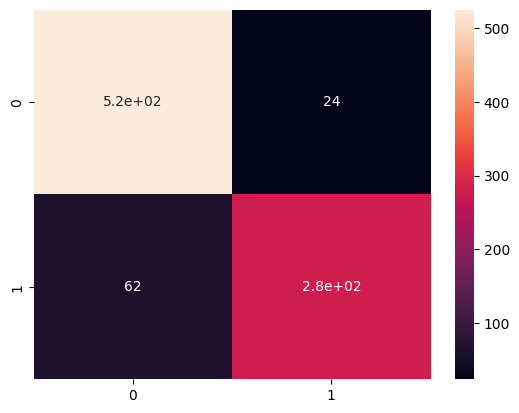

In [18]:
sb.heatmap(confusion_matrix(y, RFC.predict(x_new_all)),annot=True)